In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%autosave 20

Autosaving every 20 seconds


# Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils

/home/jd/miniconda3/envs/eva/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jd/miniconda3/envs/eva/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/jd/miniconda3/envs/eva/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


# Transformations

In [3]:
data_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Load dataset

In [4]:
train = datasets.MNIST('../data', train=True, download=True,transform=data_transforms)
test = datasets.MNIST('../data', train=True, download=True,transform=data_transforms)

# Dataloaders: Test/Train dataset

In [5]:
batch_size = 128
learning_rate = 0.01

In [6]:
SEED = 3

# is cuda available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle = True, batch_size = batch_size, num_workers = 4,pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, ** dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics & Sample Data

In [7]:
# converting array into numpy from tensor
train_data = train.train_data
train_data = train.transform(train.train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


/home/jd/miniconda3/envs/eva/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Mean & Std Values to Normalize dataset

In [9]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('../data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# Basic Model

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # input_size = 26 output_size = 24 receptive_field = 5
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # input_size = 24 output_size = 22 receptive_field = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 22 output_size = 11 receptive_field = 9
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()

        ) # input_size = 11 output_size = 11 receptive_field = 9

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()

        ) # input_size = 11 output_size = 9 receptive_field = 13
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()

        ) # input_size = 9 output_size = 7 receptive_field = 17
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()

        ) # input_size = 7 output_size = 5 receptive_field = 21
        # OUTPUT BLOCK
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # input_size = 5 output_size = 1  receptive_field = 29

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False)  
        ) # input_size = 5 output_size = 1  receptive_field = 29

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [11]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 15, 22, 22]           1,350
              ReLU-6           [-1, 15, 22, 22]               0
         MaxPool2d-7           [-1, 15, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             150
              ReLU-9           [-1, 10, 11, 11]               0
           Conv2d-10             [-1, 10, 9, 9]             900
             ReLU-11             [-1, 10, 9, 9]               0
           Conv2d-12             [-1, 10, 7, 7]             900
             ReLU-13             [-1, 10, 7, 7]               0
           Conv2d-14             [

#Training & Testing

In [12]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train & Test model

In [13]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
EPOCHS = 16
for epoch in range(1,EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=2.302537679672241 Batch_id=468 Accuracy=8.76: 100%|█| 469/469 [00:01<00:00,



Test set: Average loss: 2.3026, Accuracy: 5853/60000 (9.76%)

EPOCH: 2


Loss=2.3025615215301514 Batch_id=468 Accuracy=11.65: 100%|█| 469/469 [00:01<00:0



Test set: Average loss: 2.3025, Accuracy: 8287/60000 (13.81%)

EPOCH: 3


Loss=2.302427053451538 Batch_id=468 Accuracy=15.46: 100%|█| 469/469 [00:01<00:00



Test set: Average loss: 2.3024, Accuracy: 10452/60000 (17.42%)

EPOCH: 4


Loss=2.301830291748047 Batch_id=468 Accuracy=18.85: 100%|█| 469/469 [00:01<00:00



Test set: Average loss: 2.3016, Accuracy: 11917/60000 (19.86%)

EPOCH: 5


Loss=0.5153012871742249 Batch_id=468 Accuracy=58.25: 100%|█| 469/469 [00:01<00:0



Test set: Average loss: 0.2489, Accuracy: 55430/60000 (92.38%)

EPOCH: 6


Loss=0.11142302304506302 Batch_id=468 Accuracy=93.83: 100%|█| 469/469 [00:01<00:



Test set: Average loss: 0.1656, Accuracy: 56923/60000 (94.87%)

EPOCH: 7


Loss=0.16459043323993683 Batch_id=468 Accuracy=95.77: 100%|█| 469/469 [00:01<00:



Test set: Average loss: 0.1173, Accuracy: 57956/60000 (96.59%)

EPOCH: 8


Loss=0.12934055924415588 Batch_id=468 Accuracy=96.68: 100%|█| 469/469 [00:01<00:



Test set: Average loss: 0.0972, Accuracy: 58191/60000 (96.98%)

EPOCH: 9


Loss=0.056859854608774185 Batch_id=468 Accuracy=97.11: 100%|█| 469/469 [00:01<00



Test set: Average loss: 0.0881, Accuracy: 58341/60000 (97.23%)

EPOCH: 10


Loss=0.08028679341077805 Batch_id=468 Accuracy=97.50: 100%|█| 469/469 [00:01<00:



Test set: Average loss: 0.0769, Accuracy: 58550/60000 (97.58%)

EPOCH: 11


Loss=0.04603226110339165 Batch_id=468 Accuracy=97.74: 100%|█| 469/469 [00:01<00:



Test set: Average loss: 0.0589, Accuracy: 58896/60000 (98.16%)

EPOCH: 12


Loss=0.11021921783685684 Batch_id=468 Accuracy=97.94: 100%|█| 469/469 [00:01<00:



Test set: Average loss: 0.0573, Accuracy: 58930/60000 (98.22%)

EPOCH: 13


Loss=0.04907907173037529 Batch_id=468 Accuracy=98.12: 100%|█| 469/469 [00:01<00:



Test set: Average loss: 0.0583, Accuracy: 58916/60000 (98.19%)

EPOCH: 14


Loss=0.0193152017891407 Batch_id=468 Accuracy=98.26: 100%|█| 469/469 [00:01<00:0



Test set: Average loss: 0.0484, Accuracy: 59103/60000 (98.50%)

EPOCH: 15


Loss=0.04134335368871689 Batch_id=468 Accuracy=98.37: 100%|█| 469/469 [00:01<00:



Test set: Average loss: 0.0504, Accuracy: 59032/60000 (98.39%)



# Ploting model result

In [14]:
train_losses = [i.item() for i in train_losses]

In [16]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training Loss')

Text(0.5, 1.0, 'Training Accuracy')

Text(0.5, 1.0, 'Test Loss')

Text(0.5, 1.0, 'Test Accuracy')

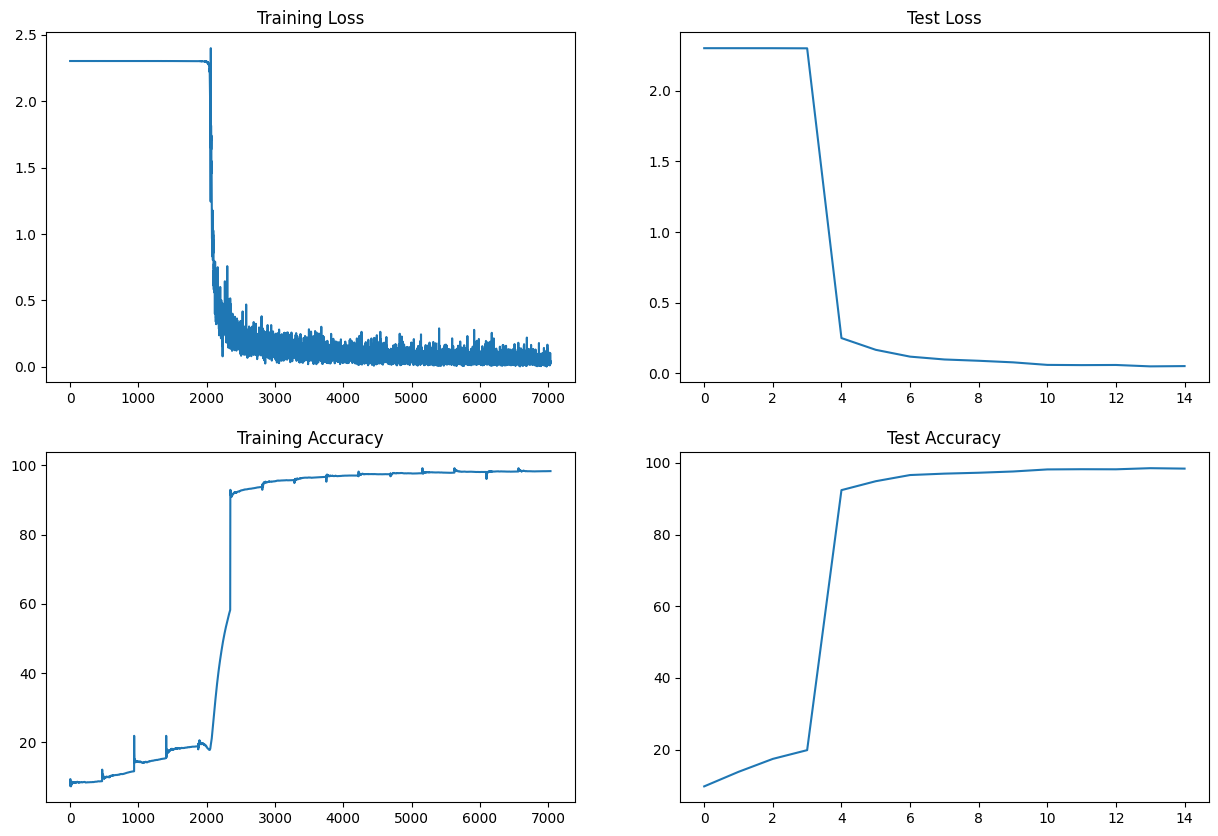

In [17]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")